# 2.1 Feature Engineering


**Objetivo:** Criar e transformar features para melhorar o desempenho dos modelos

## Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Carregamento dos Dados Limpos

In [2]:
data_path = Path('../data/interim/Cardiovascular_Disease_Dataset_clean.csv')
df = pd.read_csv(data_path, sep = ";")

print(f"Dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
df.head()

Dataset: 947 linhas x 14 colunas


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,119250,40,1,0,94,229.0,0,1,115,0,3.7,1,1,0
1,119372,49,1,2,133,142.0,0,0,202,1,5.0,1,0,0
2,132514,43,1,0,138,295.0,1,1,153,0,3.2,2,2,1
3,168686,79,1,2,130,240.0,0,2,157,0,2.5,2,1,1
4,170498,52,1,0,127,345.0,0,0,192,1,4.9,1,0,0


## Criação de Novas Features

In [3]:
# Categorizando as features numéricas

# Categorização da idade
df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 40, 60, 120],
    labels=[0, 1, 2]  # 0=jovem, 1=meia-idade, 2=idoso
)

# Categorização do colesterol sérico
df['chol_category'] = pd.cut(
    df['serumcholestrol'],
    bins=[0, 200, 240, 700],
    labels=[0, 1, 2]  # 0=normal, 1=limítrofe, 2=alto
)

# Categorização da pressão arterial sistólica
df['bp_category'] = pd.cut(
    df['restingBP'],
    bins=[0, 120, 160, 240],
    labels=[0, 1, 2]  # 0=normal, 1=elevada, 2=alta
)


# Colesterol ajustado pela idade
df['cholesterol_age_ratio'] = df['serumcholestrol'] / df['age']

# Índice pressão arterial × idade
df['bp_age_index'] = df['restingBP'] * df['age']

# Reserva cronotrópica
df['chronotropic_reserve'] = df['maxheartrate'] / (220 - df['age'])


print("Novas features criadas:")
print("- age_group (int): 0=jovem | 1=meia-idade | 2=idoso")
print("- chol_category (int): 0=normal | 1=limítrofe | 2=alto")
print("- bp_category (int): 0=normal | 1=elevada | 2=alta")
print("- cholesterol_age_ratio (float)")
print("- bp_age_index (float)")
print("- chronotropic_reserve (float)")

print(f"\nDataset após criação de features: {df.shape[0]} linhas x {df.shape[1]} colunas")

df.head(10)


Novas features criadas:
- age_group (int): 0=jovem | 1=meia-idade | 2=idoso
- chol_category (int): 0=normal | 1=limítrofe | 2=alto
- bp_category (int): 0=normal | 1=elevada | 2=alta
- cholesterol_age_ratio (float)
- bp_age_index (float)
- chronotropic_reserve (float)

Dataset após criação de features: 947 linhas x 20 colunas


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,age_group,chol_category,bp_category,cholesterol_age_ratio,bp_age_index,chronotropic_reserve
0,119250,40,1,0,94,229.0,0,1,115,0,3.7,1,1,0,0,1,0,5.725000,3760,0.638889
1,119372,49,1,2,133,142.0,0,0,202,1,5.0,1,0,0,1,0,1,2.897959,6517,1.181287
2,132514,43,1,0,138,295.0,1,1,153,0,3.2,2,2,1,1,2,1,6.860465,5934,0.864407
3,168686,79,1,2,130,240.0,0,2,157,0,2.5,2,1,1,2,1,1,3.037975,10270,1.113475
4,170498,52,1,0,127,345.0,0,0,192,1,4.9,1,0,0,1,2,1,6.634615,6604,1.142857
5,188225,62,1,0,121,357.0,0,1,138,0,2.8,0,0,0,2,2,1,5.758065,7502,0.873418
6,192523,61,0,0,190,181.0,0,1,150,0,2.9,2,0,1,2,0,2,2.967213,11590,0.943396
7,201030,59,0,1,190,529.0,1,1,151,1,3.2,2,2,1,1,2,2,8.966102,11210,0.937888
8,208877,58,1,2,192,409.0,1,0,138,0,2.3,3,1,1,1,2,2,7.051724,11136,0.851852
9,223295,27,1,0,129,135.0,0,1,192,1,1.0,0,0,0,0,0,1,5.000000,3483,0.994819


## Seleção de Features para Modelagem

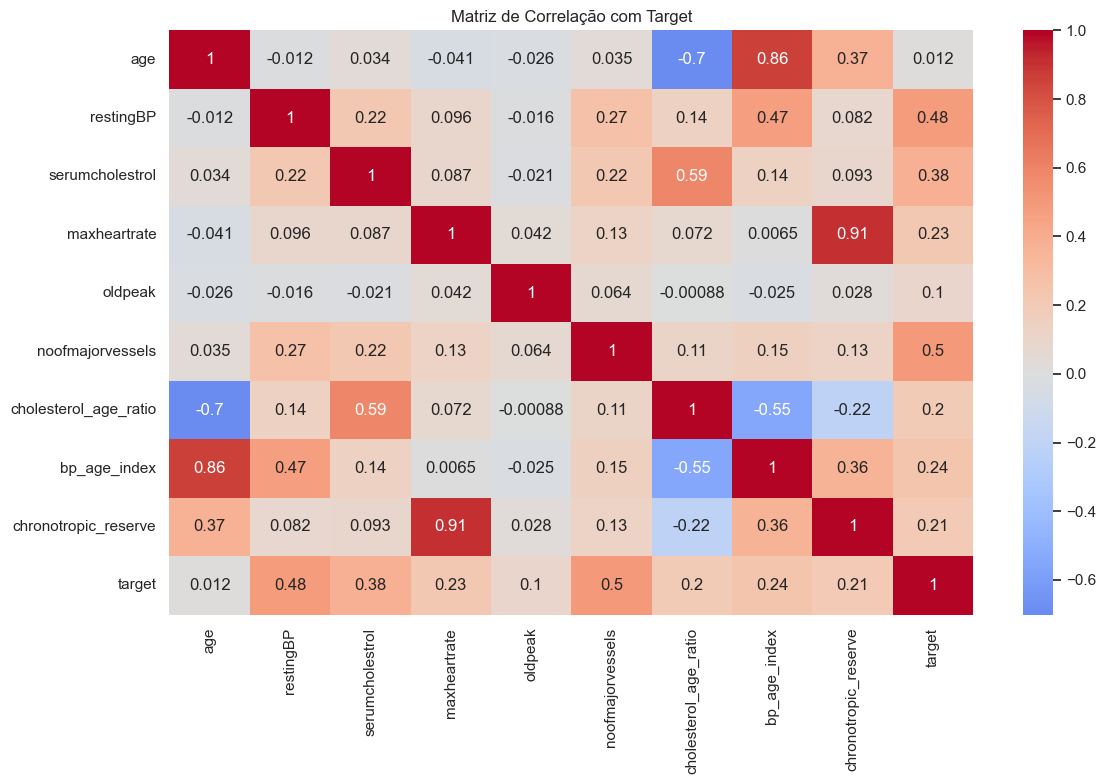

Correlação das features com o target:
target                   1.000000
noofmajorvessels         0.497155
restingBP                0.484307
serumcholestrol          0.377729
bp_age_index             0.244249
maxheartrate             0.225461
chronotropic_reserve     0.207854
cholesterol_age_ratio    0.201727
oldpeak                  0.100120
age                      0.011699
Name: target, dtype: float64

Features selecionadas por correlação (> 0.1):
['noofmajorvessels', 'bp_age_index', 'maxheartrate', 'chronotropic_reserve', 'cholesterol_age_ratio', 'oldpeak']

Features finais selecionadas: 13
['noofmajorvessels', 'bp_age_index', 'maxheartrate', 'chronotropic_reserve', 'cholesterol_age_ratio', 'oldpeak', 'gender', 'chestpain', 'restingelectro', 'slope', 'age_group', 'chol_category', 'bp_category']


In [4]:
# Seleção de features baseada em correlação e importância

# Correlação com o target
numerical_features = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']
correlation_matrix = df[numerical_features + ['target']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação com Target')
plt.tight_layout()
plt.show()

# Features com maior correlação absoluta com target
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
print("Correlação das features com o target:")
print(target_corr)

# Seleção baseada em threshold de correlação
correlation_threshold = 0.1
selected_features_corr = target_corr[target_corr > correlation_threshold].index.tolist()
selected_features_corr.remove('target') 

# Remover features originais se suas categorizações estiverem presentes
if 'restingBP' in selected_features_corr:
    selected_features_corr.remove('restingBP')
if 'serumcholestrol' in selected_features_corr:
    selected_features_corr.remove('serumcholestrol')
if 'age' in selected_features_corr:
    selected_features_corr.remove('age')    

print(f"\nFeatures selecionadas por correlação (> {correlation_threshold}):")
print(selected_features_corr)

# Features categóricas
categorical_features = ['gender', 'chestpain', 'restingelectro', 'slope', 'age_group', 'chol_category', 'bp_category']

# Lista final de features selecionadas
selected_features = selected_features_corr + categorical_features
print(f"\nFeatures finais selecionadas: {len(selected_features)}")
print(selected_features)

## Normalização de Features Numéricas

In [5]:
# Normalização das features numéricas

numerical_features_to_scale = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numerical_features_to_scale] = scaler.fit_transform(df[numerical_features_to_scale])

print("Features numéricas normalizadas usando StandardScaler:")
print(numerical_features_to_scale)

print("\nEstatísticas após normalização:")
print(df_scaled[numerical_features_to_scale].describe().round(3))

Features numéricas normalizadas usando StandardScaler:
['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels', 'cholesterol_age_ratio', 'bp_age_index', 'chronotropic_reserve']

Estatísticas após normalização:
           age  restingBP  serumcholestrol  maxheartrate  oldpeak  \
count  947.000    947.000          947.000       947.000  947.000   
mean     0.000     -0.000            0.000        -0.000    0.000   
std      1.001      1.001            1.001         1.001    1.001   
min     -1.639     -1.899           -2.158        -2.148   -1.583   
25%     -0.856     -0.768           -0.716        -0.784   -0.821   
50%     -0.017     -0.235           -0.025        -0.000   -0.176   
75%      0.878      0.979            0.718         0.870    0.820   
max      1.717      1.628            2.417         1.654    2.051   

       noofmajorvessels  cholesterol_age_ratio  bp_age_index  \
count           947.000                947.000       947.000   
mean      

## Visualização das Features Transformadas

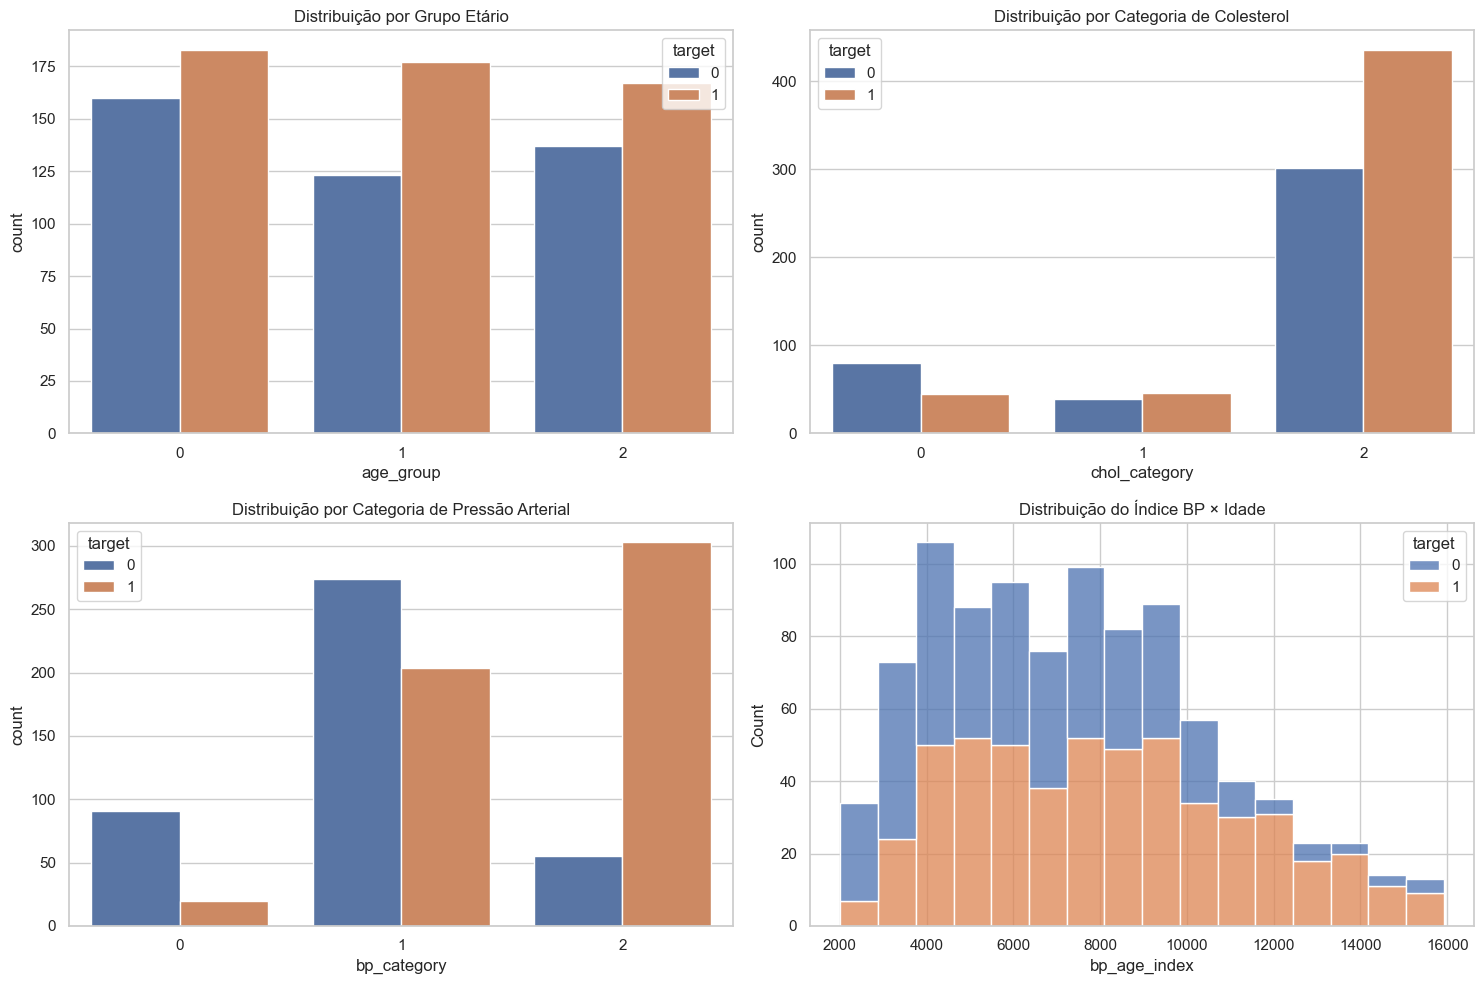

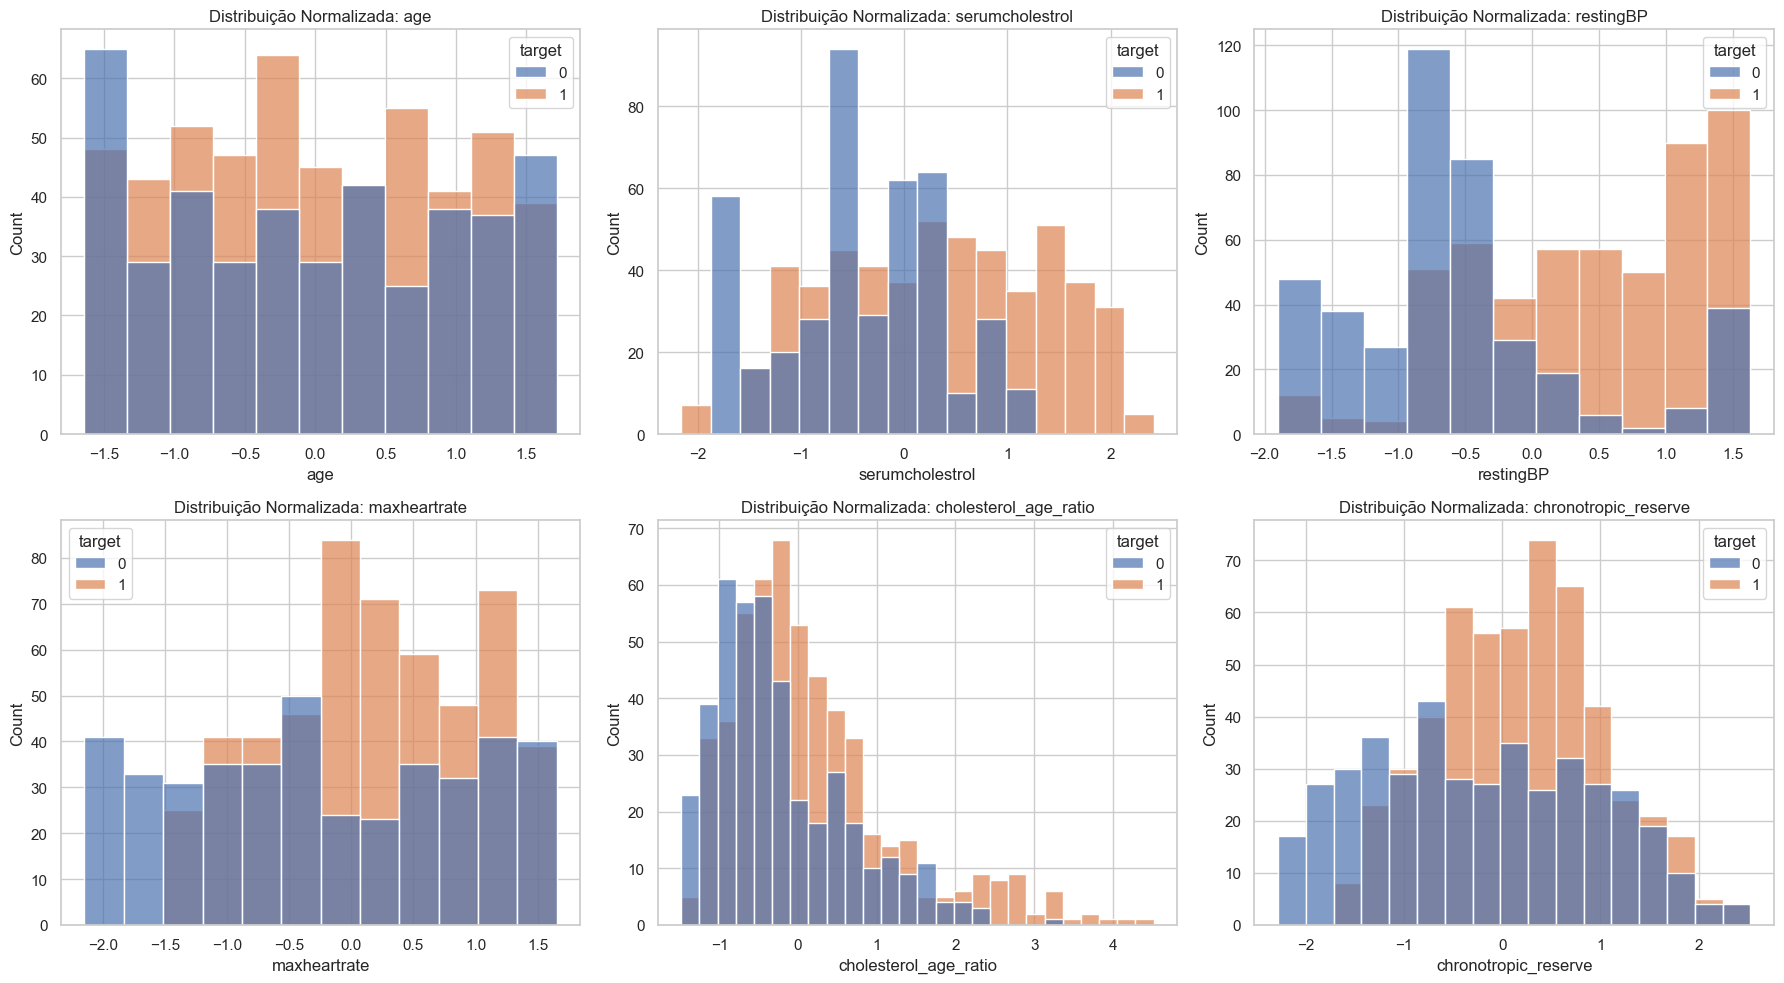

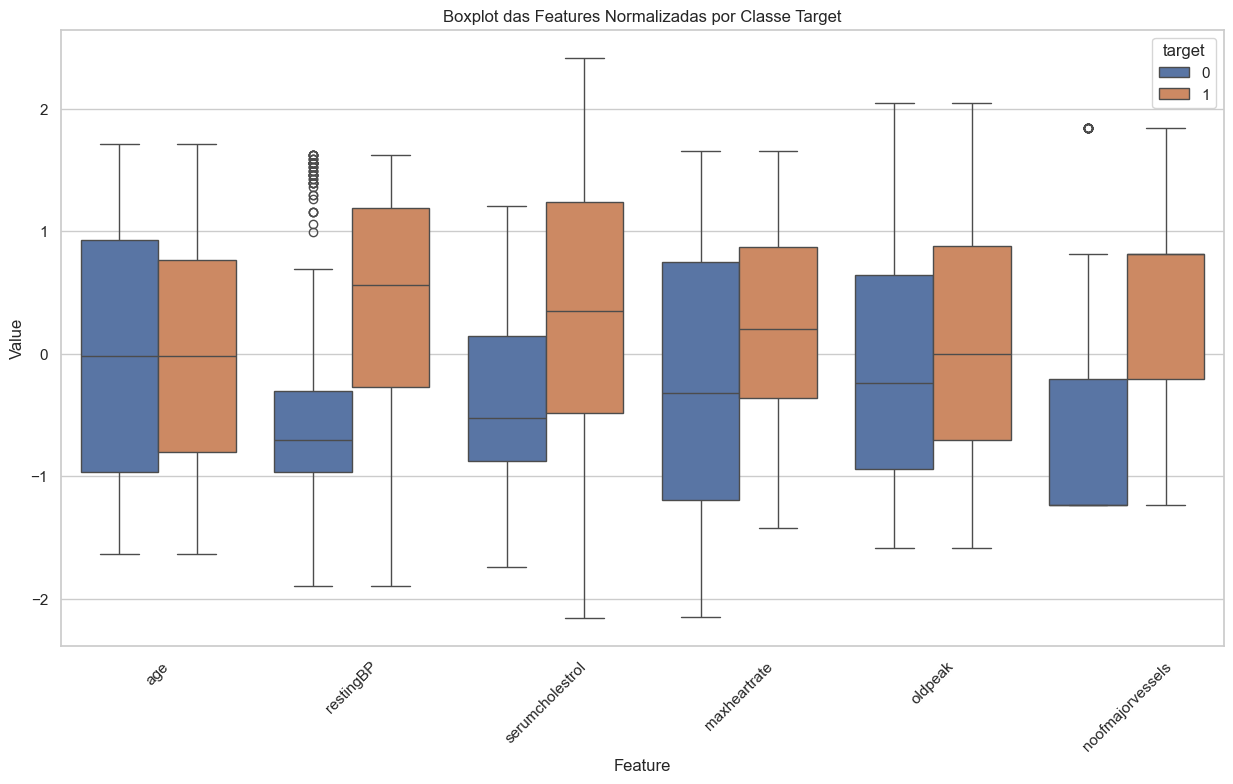

In [6]:
# Visualização das features transformadas

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age groups
sns.countplot(data=df, x='age_group', hue='target', ax=axes[0,0])
axes[0,0].set_title('Distribuição por Grupo Etário')

# Cholesterol categories
sns.countplot(data=df, x='chol_category', hue='target', ax=axes[0,1])
axes[0,1].set_title('Distribuição por Categoria de Colesterol')

# BP categories
sns.countplot(data=df, x='bp_category', hue='target', ax=axes[1,0])
axes[1,0].set_title('Distribuição por Categoria de Pressão Arterial')

# BP Age Index
sns.histplot(data=df, x='bp_age_index', hue='target', multiple='stack', ax=axes[1,1])
axes[1,1].set_title('Distribuição do Índice BP × Idade')

plt.tight_layout()
plt.show()

#  Distribuição das features numéricas normalizadas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features_to_plot = ['age', 'serumcholestrol', 'restingBP', 'maxheartrate', 'cholesterol_age_ratio', 'chronotropic_reserve']

for i, feature in enumerate(features_to_plot):
    row = i // 3
    col = i % 3
    sns.histplot(data=df_scaled, x=feature, hue='target', ax=axes[row, col], alpha=0.7)
    axes[row, col].set_title(f'Distribuição Normalizada: {feature}')

plt.tight_layout()
plt.show()

# Boxplot das features normalizadas por target
plt.figure(figsize=(15, 8))
df_melted = df_scaled.melt(id_vars=['target'], value_vars=numerical_features_to_scale[:6], var_name='Feature', value_name='Value')
sns.boxplot(data=df_melted, x='Feature', y='Value', hue='target')
plt.title('Boxplot das Features Normalizadas por Classe Target')
plt.xticks(rotation=45)
plt.show()

## Salvamento dos Dados Processados

In [7]:
# Salvamento dos dados processados

processed_data_dir = Path('../data/processed')
processed_data_dir.mkdir(parents=True, exist_ok=True)

# dataset com features originais + novas
processed_file = processed_data_dir / 'cardiovascular_processed.csv'
df.to_csv(processed_file, index=False, sep=";")

# dataset normalizado
processed_scaled_file = processed_data_dir / 'cardiovascular_processed_scaled.csv'
df_scaled.to_csv(processed_scaled_file, index=False, sep=";")

# Salvar scaler 
scaler_file = processed_data_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_file)

print("Dados processados salvos:")
print(f"- {processed_file}")
print(f"- {processed_scaled_file}")
print(f"- {scaler_file}")

print(f"\nResumo final:")
print(f"Dataset processado: {df.shape[1]} features")
print(f"Features criadas: 6 novas features")
print(f"Features selecionadas: {len(selected_features)}")
print(f"Features normalizadas: {len(numerical_features_to_scale)}")

Dados processados salvos:
- ..\data\processed\cardiovascular_processed.csv
- ..\data\processed\cardiovascular_processed_scaled.csv
- ..\data\processed\scaler.pkl

Resumo final:
Dataset processado: 20 features
Features criadas: 6 novas features
Features selecionadas: 13
Features normalizadas: 9
